In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import argparse
import imutils
import pydicom

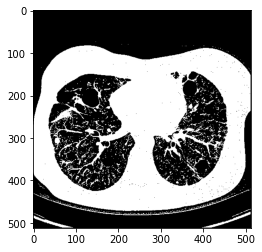

In [3]:
path = "image/ILD/2/gray/FILE0_gray.jpg"
img = cv2.imread(path , 0)
plt.imshow(img , 'gray')
canny = cv2.Canny(img , 30 , 150)

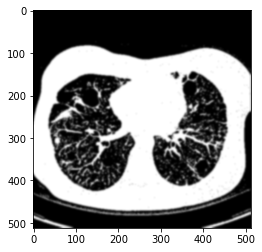

In [4]:
blurred = cv2.GaussianBlur(img, (11, 11), 0)#高斯模糊化
plt.imshow(blurred , 'gray')

In [1860]:
canny = cv2.Canny(blurred , 30 , 150)
# plt.imshow(canny , 'gray')
temp = np.zeros(canny.shape)

In [1873]:
print(temp)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 各種Function

In [713]:
def mask(rootpath , image , count):
    path = rootpath + "/lung_mask/JPG/" + image
#     path = rootpath + "/gray/" + image
    img = cv2.imread(path , 0)
    # blurred = cv2.GaussianBlur(img, (11, 11), 0)#高斯模糊化
    canny = cv2.Canny(img , 30 , 150)#threshold_one and threshold_two
    # canny = cv2.Canny(img , 30 , 150)
    canny = cv2.dilate(canny , None)
    canny = cv2.erode(canny , None)

    #Parameter 
    BLUR = 21
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0 , 0.0 , 0.0) #In RGB format

    contour_info = []
    contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))

    contour_info = sorted(contour_info , key = lambda c: c[2] , reverse = True)

    #create empty mask, draw filled polygon on its corresponding to largest contour
    #Mask is black, polygon is white
    mask = np.zeros(canny.shape)
    max_contour = contour_info[count-1]
    cv2.fillConvexPoly(mask , max_contour[0] , (255))

    #smooth mask then blur it
    mask = cv2.dilate(mask , None , iterations = MASK_DILATE_ITER)
    mask = cv2.erode(mask , None , iterations = MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask , (BLUR , BLUR) , 0)
    
    plt.subplot(3,3,count),plt.imshow(mask)
def segmentation(rootpath , image , jpgpath , jpg):
    path = rootpath + "/lung_mask/JPG/" + image
    des_path = rootpath + "/Segmentation/"#jpg segmentation destination
    if not os.path.isdir(des_path):
        os.mkdir(des_path)
    img = cv2.imread(path , 0)
    canny = cv2.Canny(img , 30 , 150)#threshold_one and threshold_two
    canny = cv2.dilate(canny , None)
    canny = cv2.erode(canny , None)
    
    #Parameter 
    BLUR = 21
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0 , 0.0 , 0.0) #In RGB format

    contour_info = []
    contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
#     contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))

    contour_info = sorted(contour_info , key = lambda c: c[2] , reverse = True)

    #create empty mask, draw filled polygon on its corresponding to largest contour
    #Mask is black, polygon is white
    mask = np.zeros(canny.shape)
    
#     for i in range(0 , len(contour_info)):
#         max_contour = contour_info[i]
#         cv2.fillConvexPoly(mask , max_contour[0] , (255))
    max_contour = contour_info[0]
    cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[1]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))  
#     max_contour = contour_info[2]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[3]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[4]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[5]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[6]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[7]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[8]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[9]


    #smooth mask then blur it
    mask = cv2.dilate(mask , None , iterations = MASK_DILATE_ITER)
    mask = cv2.erode(mask , None , iterations = MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask , (BLUR , BLUR) , 0)
    
#     plt.imshow(mask)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    img = img[: , : , np.newaxis]
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    path2 = jpgpath + jpg
    temp1 = cv2.imread(path2)
#     temp1 = cv2.imread("Database/ILD_DB_volumeROls/21/JPG/CT-2336-0009.jpg")
#     plt.subplot(1,2,1),plt.imshow(mask,'gray')
#     plt.subplot(1,2,2),plt.imshow(temp1,'gray')
    temp1 = temp1.astype('float32') / 255.0
    org = mask_stack * temp1 + ((1-mask_stack) * MASK_COLOR)
    org = (org * 255).astype('uint8')
    cv2.imwrite(des_path + jpg , org)
    plt.imshow(mask)
#     return canny , max_contour[0]

#     cv2.imwrite("Database/ILD_DB_lungMasks/3/Orginal.jpg" , temp1)
#     plt.subplot(1,3,1)
#     plt.imshow(mask)
#     plt.subplot(1,3,2)
#     plt.imshow(org , 'gray')
#     plt.subplot(1,3,3)
#     plt.imshow(masked)
#     cv2.imwrite(rootpath+ "/Segmentation/15_" + str((int)(image.split('_')[1]) - 1) + ".jpg" , org)
#     cv2.imwrite((rootpath + "/mask/" + image.split('.')[0] + "_masked.jpg"), masked)
def get_edge(rootpath , image):#取得edge
    path = rootpath + image
    img = cv2.imread(path , 0)
    canny = cv2.Canny(img , 30 , 150)#threshold_one and threshold_two
    return canny
def get_mask(maskpath , mask , jpgpath , jpg):#segment ct through lung_mask masked picture
    path = maskpath + mask
    print(path)
    img = cv2.imread(path , 0)
    img = 1-img
    plt.imshow(img,'gray')

### 將ROI region 和CT image 疊在一起的Cover(利用Canny抓出roi_mask的 contour)

In [808]:
count = 0
for item in file_list:
#     print(count , item)
    count = count + 1
rootpath = "Database/ILD_DB_volumeROls/9/"
jpg_list = []
roi_list = []
for file in os.listdir(rootpath + "JPG/"):
    jpg_list.append(file)
for file in os.listdir(rootpath + "roi_mask/JPG"):
    roi_list.append(file)

59


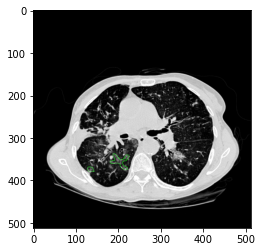

In [824]:
rootpath = "Database/ILD_DB_volumeROls//"
# arr = get_edge(path , "roi_mask_7771_13.jpg")
# img = cv2.imread("Database/ILD_DB_volumeROls/7/JPG/CT-7771-0013.jpg")
# for i in range(0,512):
#     for j in range(0,512):
#         if arr[i,j] == 255:
#             img[i,j,:] = 255
file_list = []
for file in os.listdir(rootpath):
    if not file.endswith('-'):
        file_list.append(file)
for element in file_list[0:1]:
    element = "59"
    if element == "142" or element == "154" or element == "184":
        print("ya")
    else:
        jpg_list = []
        roi_list = []
        print(element)
        patient = element
        path = rootpath + patient + "/roi_mask/JPG/"
        des_path = rootpath + patient + "/Cover"
        if not os.path.isdir(des_path):#create cover file in each image file
            os.mkdir(des_path)
        for file in os.listdir(rootpath + element + "/JPG/"):
            if file.endswith(".jpg"):
                jpg_list.append(file)
        for file in os.listdir(rootpath + element + "/roi_mask/JPG"):
            if file.endswith(".jpg"):
                roi_list.append(file)
        for item in roi_list:
            arr = get_edge(path , item)
            name = int(item.split('_')[3].split('.')[0])
            for item2 in jpg_list:
                if name == int(item2.split('.')[0][-2] + item2.split('.')[0][-1]):
                    img = cv2.imread(rootpath + patient + "/JPG/" + item2)
                    for i in range(0,512):
                        for j in range(0,512):
                            if arr[i,j] == 255:
                                img[i,j,1] = 255
                    plt.imshow(img , 'gray')
                    cv2.imwrite(des_path + '/' + item2 , img)
                    break
#             以下code 給命名較特別的資料夾 如171等等
#             name = int(item.split('_')[3].split('.')[0])
#             item2 = jpg_list[name-1]#item2 為CT Image 的JPG
#             img = cv2.imread(rootpath + patient + "/JPG/" + item2)
#             for i in range(0,512):
#                 for j in range(0,512):
#                     if arr[i,j] == 255:
#                         img[i,j,1] = 255
#             plt.imshow(img , 'gray')
#             cv2.imwrite(des_path + '/' + item2 , img)

### 以下code為用來處理image Segmentation

87
image/test/15/
N2_10_gray.jpg
9
(512, 512)


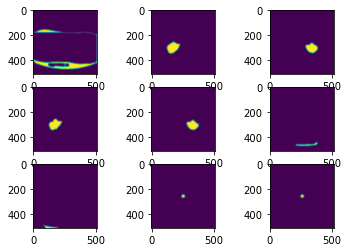

In [75]:
path = "image/test/15/"#change XXX to specific folder
des_path = path + "/mask" 
if not os.path.isdir(des_path):#create mask file in each image file
    os.mkdir(des_path)
seg_path = path + "/Segmentation"
if not os.path.isdir(seg_path):#create segmentation file in each image file
    os.mkdir(seg_path)
imagelist = []
filename = r".jpg"#confirm the file name end with jpg
for file in os.listdir((path + "/gray")):
    if file.endswith(filename):
        imagelist.append(file)
print(len(imagelist))
print(path)
image_path = path + "/gray"
count = 0
for image in imagelist[0:1]:#imagelist 為 jpg 檔的名稱
#     image = imagelist[85]
    print(image)
    print(str((int)(image.split('_')[1]) - 1))
#     print(str((int)((image.split('_')[0]).split('E')[1])))
#     print(str(cc) + '1')
    segmentation(path , image)
    for i in range(1 , 10):
        mask(path , image , i)

## DataBase 的Segmentation(利用Lung_mask)

In [811]:
path = "Database/ILD_DB_lungMasks/"
path2 = "Database/ILD_DB_volumeROls/"
filelist = []
temp = []
for file in os.listdir(path):
    filelist.append(file)
for file in filelist:
    for item in os.listdir(path + file + "/"):
        if item == "lung_mask":
            temp.append(file)
            print(file)
            break
filelist = temp
print("---" , len(filelist))
for file in os.listdir(path2):
    jpg_list.append(file)

21
23
3
34
35
36
37
38
39
41
45
46
47
48
51
53
54
56
57
58
59
62
65
66
7
70
74
76
77
78
80
81
82
83
84
89
90
92
94
--- 39


In [819]:
imglist = []
for file in filelist[-2:-1]:
    file = "9"
    des_path = path2 + file + "/Segmentation/"
    print(des_path)
    if not os.path.isdir(des_path):
        os.mkdir(des_path)
    print(file)
    for item in os.listdir(path + file + "/lung_mask/JPG"):
#         segmentation(path+file+"/lung_mask/JPG/" , item)
        name = int(item.split('_')[3].split('.')[0])
        for item2 in os.listdir(path2 + file + "/JPG"):
            if name == int(item2.split('.')[0][-2] + item2.split('.')[0][-1]):
                jpg = cv2.imread(path2+file+"/JPG/"+item2,0)
                img = cv2.imread(path+file+"/lung_mask/JPG/"+item,0)
                for i in range(0,512):
                    for j in range(0,512):
                        if img[i,j] <= 200:
                            jpg[i,j] = 0
                cv2.imwrite(des_path+item2,jpg)
                break

Database/ILD_DB_volumeROls/9/Segmentation/
9


### 利用lung_mask的Segmentation

True

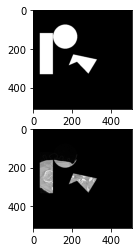

In [10]:
# print(namejpg)
# jpg = cv2.imread(path2+"94/JPG/CT-7370-0022.jpg",0)
jpg = cv2.imread("CT-7358-0001.jpg" , 0)
# img = cv2.imread(path+"94/lung_mask/JPG/lung_mask_7370_22.jpg",0)
img = cv2.imread("test.jpg" , 0)
plt.subplot(2,1,1),plt.imshow(img,'gray')
plt.subplot(2,1,2),plt.imshow(jpg,'gray')
for i in range(0,512):
    for j in range(0,512):
        if img[i,j] <= 127:
            jpg[i,j] = 0
plt.imshow(jpg,'gray')
cv2.imwrite("result.jpg" , jpg)
# cv2.imwrite(path+file+"/Segmentation/"+namejpg,jpg)
# print(path+file+"/Segmentation/"+namejpg)
# plt.imshow(jpg,'gray')

### 修改Image的size

In [800]:
import PIL.Image
img_list = []
path3 = "Database/ILD_DB_lungMasks/94/lung_mask/JPG/"
for file in os.listdir(path3):
    img_list.append(file)
    print(file)
size = 512
for file in img_list:
    img = PIL.Image.open(path3+file)
    out = img.resize((size,size),PIL.Image.ANTIALIAS)
    out.save(path3+file)

lung_mask_7370_1.jpg
lung_mask_7370_10.jpg
lung_mask_7370_11.jpg
lung_mask_7370_12.jpg
lung_mask_7370_13.jpg
lung_mask_7370_14.jpg
lung_mask_7370_15.jpg
lung_mask_7370_16.jpg
lung_mask_7370_17.jpg
lung_mask_7370_18.jpg
lung_mask_7370_19.jpg
lung_mask_7370_2.jpg
lung_mask_7370_20.jpg
lung_mask_7370_21.jpg
lung_mask_7370_22.jpg
lung_mask_7370_23.jpg
lung_mask_7370_24.jpg
lung_mask_7370_25.jpg
lung_mask_7370_3.jpg
lung_mask_7370_4.jpg
lung_mask_7370_5.jpg
lung_mask_7370_6.jpg
lung_mask_7370_7.jpg
lung_mask_7370_8.jpg
lung_mask_7370_9.jpg


## -----------------------------------------------------------------------------------------------------------------------------

In [266]:
path = "Database/ILD_DB_volumeROls/"
filelist = []
for file in os.listdir(path):
    filelist.append(file)
filename = r".dcm"
for file in filelist[1:2]:    
    print(file)
    ctlist = []
    roilist = []
    underfile = []#下一層的資料夾
    filepath = path + '/' + file
    des = filepath + "/Cover"
    if not os.path.isdir(des):
        os.mkdir(des)
    for file in os.listdir(filepath):
        if file.endswith(filename):
            ctlist.append(file)
        else:
            underfile.append(file)
    for name in underfile:
        if name == "roi_mask":
            for file in os.listdir((filepath + "/roi_mask")):
                if file.endswith(filename):
                    roilist.append(file)
# for item in roilist:
#     print(item)
# for item in ctlist:
#     print(item)
for i in range(6,10):
    item = str(i)
    image = "roi_mask_1376_" + item + ".dcm"
#     print(image)
#     print("roi_mask_7771_4.dcm")
    ds = pydicom.dcmread("Database/ILD_DB_volumeROls/17/roi_mask/" + image)
    img = cv2.imread("Database/ILD_DB_volumeROls/17/JPG/CT-1376-000" + item + ".jpg")
    Array_dicom = np.zeros(ds.pixel_array.shape)
    Array_dicom = ds.pixel_array
    for i in range(0,512):
        for j in range(0,512):
            if Array_dicom[i,j] == 0:
                img[i,j,:] = 0
    #             print(Array_dicom[i][j])
    #             Array_dicom[i][j] = 127
    #             print(i)
    #             print(j)
    # plt.imshow(img)
    cv2.imwrite("Database/ILD_DB_volumeROls/17/Cover/" + item + ".jpg" , img)
    # cv2.imwrite("Database/ILD_DB_volumeROls/3/roi_mask/roi_mask_7358_15.jpg" , Array_dicom)

105
